In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Paths
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25

In [3]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,         
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    zoom_range=0.2,
    shear_range=0.15,            
    horizontal_flip=True,
    fill_mode='nearest'          
)

# No augmentation for validation and test, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Found 5537 images belonging to 2 classes.
Found 1186 images belonging to 2 classes.
Found 1188 images belonging to 2 classes.


In [4]:
# Class Weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.594758064516129, 1: 0.7283609576427256}


In [5]:
# Base Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

2025-04-24 01:57:13.035270: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-24 01:57:13.035304: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-24 01:57:13.035308: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-24 01:57:13.035328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-24 01:57:13.035340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("resnet_model.keras", save_best_only=True, verbose=1)
]

In [7]:
# Train
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=callbacks)

/opt/homebrew/Caskroom/miniforge/base/envs/cnn-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


2025-04-24 01:57:16.401059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5151 - loss: 1.0190  
Epoch 1: val_loss improved from inf to 0.69630, saving model to resnet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.5150 - loss: 1.0189 - val_accuracy: 0.4207 - val_loss: 0.6963
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.4954 - loss: 0.9533  
Epoch 2: val_loss improved from 0.69630 to 0.65020, saving model to resnet_model.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 110s 632ms/step - accuracy: 0.4954 - loss: 0.9533 - val_accuracy: 0.6863 - val_loss: 0.6502
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.4963 - loss: 0.9533  
Epoch 3: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 114s 652ms/step - accuracy: 0.4962 - loss: 0.9534 - val_accuracy: 0.3609 - val_loss: 0.7367
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5058 - loss: 0.9194  
Epoch 4: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━

In [8]:
# Fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 25
history_fine = model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=fine_tune_epochs,
                         class_weight=class_weights,
                         callbacks=callbacks)

Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6184 - loss: 1.1553  
Epoch 1: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.6185 - loss: 1.1540 - val_accuracy: 0.3137 - val_loss: 4.2305
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7147 - loss: 0.6948  
Epoch 2: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.7148 - loss: 0.6945 - val_accuracy: 0.3137 - val_loss: 2.8271
Epoch 3/20
 48/174 ━━━━━━━━━━━━━━━━━━━━ 6:36 3s/step - accuracy: 0.7676 - loss: 0.5451

/opt/homebrew/Caskroom/miniforge/base/envs/cnn-env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7785 - loss: 0.5202 - val_accuracy: 0.3137 - val_loss: 3.2200
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7943 - loss: 0.4873  
Epoch 4: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.7944 - loss: 0.4873 - val_accuracy: 0.3373 - val_loss: 1.6233
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8374 - loss: 0.4151  
Epoch 5: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.8374 - loss: 0.4151 - val_accuracy: 0.6189 - val_loss: 1.0877
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8517 - loss: 0.3688  
Epoch 6: val_loss did not improve from 0.65020
174/174 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - accuracy: 0.8518 - loss: 0.3687 - val_accuracy: 0.6863 - val_loss: 1.7217
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8828 - loss: 

In [9]:
# Evaluate on Test
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32")
y_true = test_generator.classes

# Accuracy
test_acc = np.mean(y_pred.flatten() == y_true)
print(f"Test Accuracy: {test_acc:.4f}")

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step
Test Accuracy: 0.9646



Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.94       373
   Malignant       0.98      0.96      0.97       815

    accuracy                           0.96      1188
   macro avg       0.95      0.96      0.96      1188
weighted avg       0.97      0.96      0.96      1188

Confusion Matrix:
[[360  13]
 [ 29 786]]


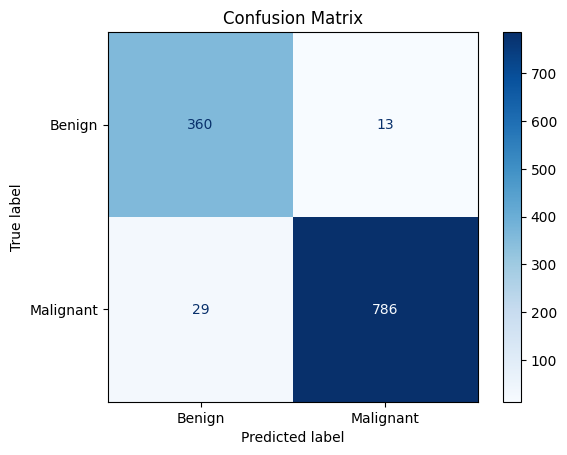

In [10]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

cm = confusion_matrix(y_true, y_pred)
# Confusion Matrix
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

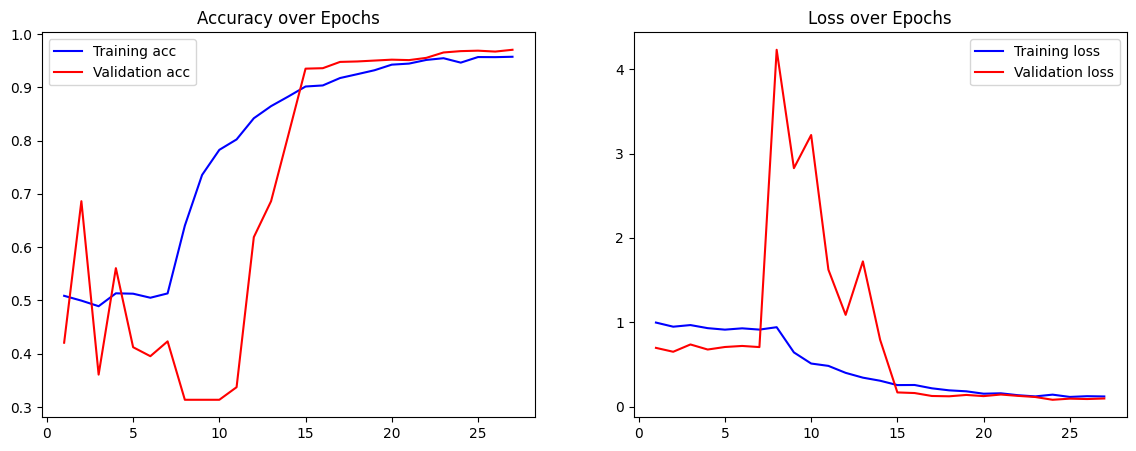

In [11]:
# Plot training
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

plot_history(history, history_fine)

In [12]:
model.save("final_resnet_model.keras")